In [ ]:
# Neural Network 1

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)


Using device: cuda


Total training samples: 60000
Total test samples: 10000
Train set size: 50000 Validation set size: 10000


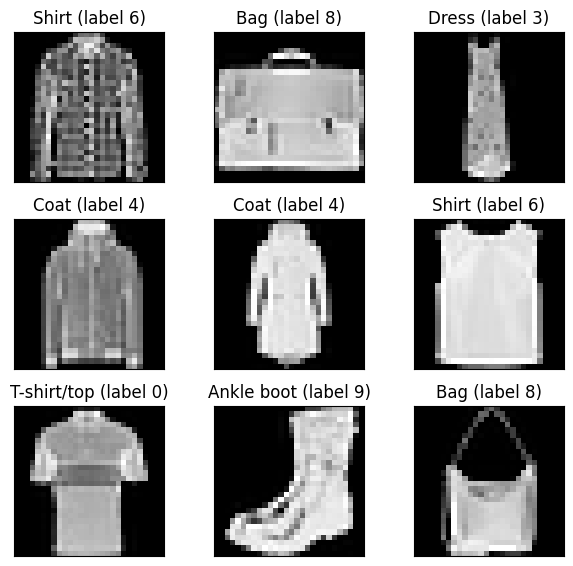

In [5]:
transform = transforms.ToTensor()
train_dataset_full = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)
print("Total training samples:", len(train_dataset_full))
print("Total test samples:", len(test_dataset))

train_size = 50000
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])
print("Train set size:", len(train_dataset), "Validation set size:", len(val_dataset))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"{classes[int(example_targets[i])]} (label {int(example_targets[i])})")
    plt.xticks([])
    plt.yticks([])
plt.show()



In [6]:
class FashionMLP(nn.Module):
    def __init__(self):
        super(FashionMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [7]:
model = FashionMLP().to(device)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))
summary(model, input_size=(1, 28, 28))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []



FashionMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)
Total parameters: 109386
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Param

In [8]:
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
    avg_train_loss = total_loss / total
    train_accuracy = correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            val_correct += (predicted == target).sum().item()
            val_total += target.size(0)
    avg_val_loss = val_loss / val_total
    val_accuracy = val_correct / val_total

    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs} - "
              f"Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f} - "
              f"Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}")


Epoch 5/30 - Train loss: 0.3166, Train acc: 0.8833 - Val loss: 0.3459, Val acc: 0.8717
Epoch 10/30 - Train loss: 0.2544, Train acc: 0.9043 - Val loss: 0.2918, Val acc: 0.8920
Epoch 15/30 - Train loss: 0.2149, Train acc: 0.9196 - Val loss: 0.3019, Val acc: 0.8898
Epoch 20/30 - Train loss: 0.1836, Train acc: 0.9304 - Val loss: 0.3091, Val acc: 0.8925
Epoch 25/30 - Train loss: 0.1622, Train acc: 0.9388 - Val loss: 0.3352, Val acc: 0.8934
Epoch 30/30 - Train loss: 0.1440, Train acc: 0.9459 - Val loss: 0.3364, Val acc: 0.8959


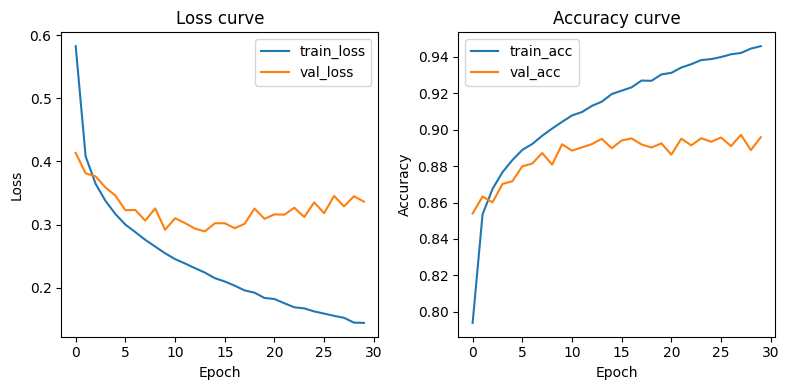

In [9]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label="train_loss")
plt.plot(val_loss_history, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curve")
plt.subplot(1,2,2)
plt.plot(train_acc_history, label="train_acc")
plt.plot(val_acc_history, label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy curve")
plt.tight_layout()
plt.show()

Модель обучилась хорошо: видно, что loss стабильно падает, а точность растёт. На 10-й эпохе достигли ~90%. После этого начинается переобучение. Валидейшн loss немного колебался, но в целом снижался, так что модель обобщает нормально. Для простой полносвязной сети — отличный результат. Дальше можно добавлять сверточные слои, чтобы достичь лучших результатов.


In [ ]:
# Neural Network 2 (with cnn)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary



In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [12]:
transform = transforms.ToTensor()

train_dataset_full = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

train_size = 50000
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [13]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 14 * 14, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_cnn = FashionCNN().to(device)
print(model_cnn)
print("Total parameters:", sum(p.numel() for p in model_cnn.parameters()))
summary(model_cnn, input_size=(1, 28, 28))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

epochs = 20
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []



FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)
Total parameters: 144266
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Linear-4                   [-1, 10]         125,450
Total params: 144,266
Trainable params: 144,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 0.55
Estimated Total Size (MB): 1.22
------------------------

In [14]:
for epoch in range(1, epochs + 1):
    model_cnn.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_cnn(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
    avg_train_loss = total_loss / total
    train_accuracy = correct / total

    model_cnn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model_cnn(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            val_correct += (predicted == target).sum().item()
            val_total += target.size(0)
    avg_val_loss = val_loss / val_total
    val_accuracy = val_correct / val_total

    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs} - "
              f"Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f} - "
              f"Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}")


Epoch 5/20 - Train loss: 0.1622, Train acc: 0.9421 - Val loss: 0.2353, Val acc: 0.9176
Epoch 10/20 - Train loss: 0.0796, Train acc: 0.9724 - Val loss: 0.2670, Val acc: 0.9203
Epoch 15/20 - Train loss: 0.0382, Train acc: 0.9874 - Val loss: 0.3497, Val acc: 0.9194
Epoch 20/20 - Train loss: 0.0219, Train acc: 0.9929 - Val loss: 0.4461, Val acc: 0.9159


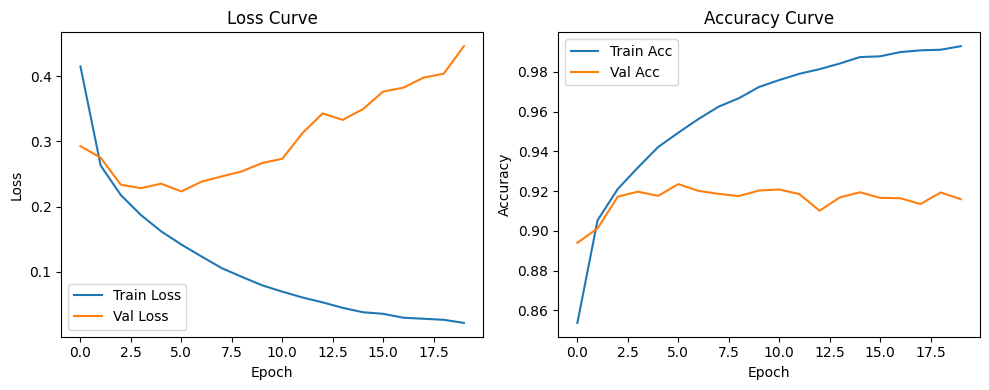

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

Модель с двумя свёртками и пуллингом справляется отлично. Точность на обучении дошла до 97.2%, на валидации — около 92.3%. Это уже заметный прирост по сравнению с MLP. Однако видно, что валидационная ошибка к концу слегка растёт — модель начала немного переобучаться. В остальном — обучение стабильное, результаты достойные. Хорошая база для следующего шага — аугментаций.

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)
Total parameters: 144266
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Linear-4                   [-1, 10]         125,450
Total params: 144,266
Trainable params: 144,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 0.55
Estimated Total Size (MB): 1.22
------------------------

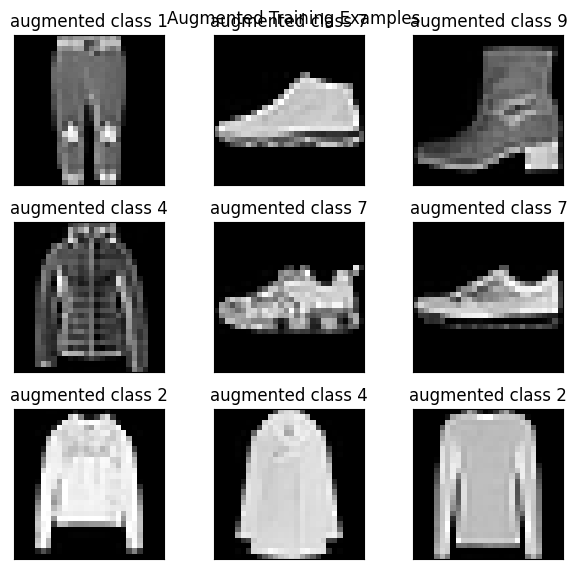

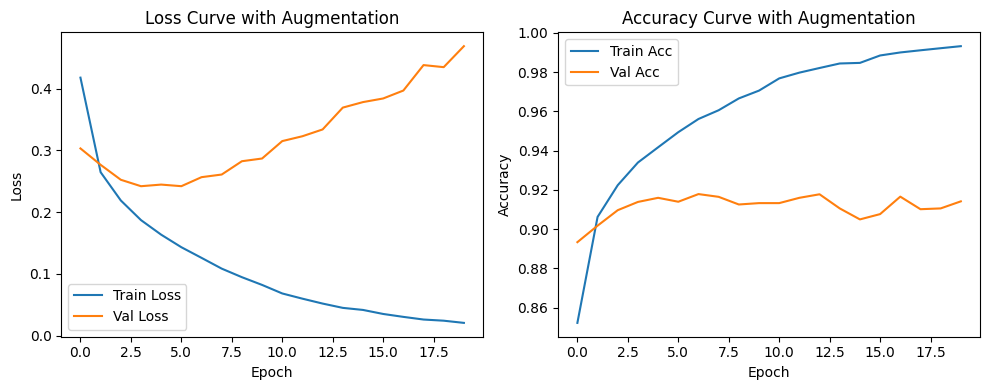

In [ ]:
# Neural Network 3 (with augmentation)

from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor()
])
transform_plain = transforms.ToTensor()

train_dataset_full_aug = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform_aug)
train_dataset_aug, val_dataset_aug = random_split(train_dataset_full_aug, [50000, 10000])
val_dataset_aug.dataset.transform = transform_plain

batch_size = 64
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=False)

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 14 * 14, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_cnn2 = FashionCNN().to(device)
print(model_cnn2)
print("Total parameters:", sum(p.numel() for p in model_cnn2.parameters()))
summary(model_cnn2, input_size=(1, 28, 28))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn2.parameters(), lr=0.001)

epochs = 20
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

for epoch in range(1, epochs+1):
    model_cnn2.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader_aug:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_cnn2(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
    avg_train_loss = total_loss / total
    train_accuracy = correct / total

    model_cnn2.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in val_loader_aug:
            data, target = data.to(device), target.to(device)
            output = model_cnn2(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            val_correct += (predicted == target).sum().item()
            val_total += target.size(0)
    avg_val_loss = val_loss / val_total
    val_accuracy = val_correct / val_total

    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs} - "
              f"Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f} - "
              f"Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}")

batch_idx, (aug_data, aug_targets) = next(enumerate(train_loader_aug))
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(aug_data[i][0].cpu(), cmap='gray', interpolation='none')
    plt.title(f"augmented class {int(aug_targets[i])}")
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Augmented Training Examples")
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve with Augmentation")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve with Augmentation")
plt.legend()

plt.tight_layout()
plt.show()


Аугментация помогла немного повысить устойчивость модели — начальная точность на валидации сразу была выше, чем без неё. Но при этом к концу обучения модель начала немного переобучаться: train loss продолжал падать, а val loss — начал расти. Валид точность колебалась и не росла дальше 91.4%. Это значит, что аугментации стоит настраивать тоньше: возможно, они слишком слабые или наоборот — слишком агрессивные. Визуально видно, что аугментированные изображения вполне естественные. Модель учится уверенно, но запас по улучшению ещё есть.

Using device: cuda
FashionResNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)
Total parameters: 153514
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 32, 28, 28]           9,248
            Conv2d-3           [-1, 64, 28, 28]          18,496
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Linear-5                   [-1, 10]         125,450
Total params: 153,514
Trainable params: 153,514
Non-trainable params: 0
-----------------------------------------

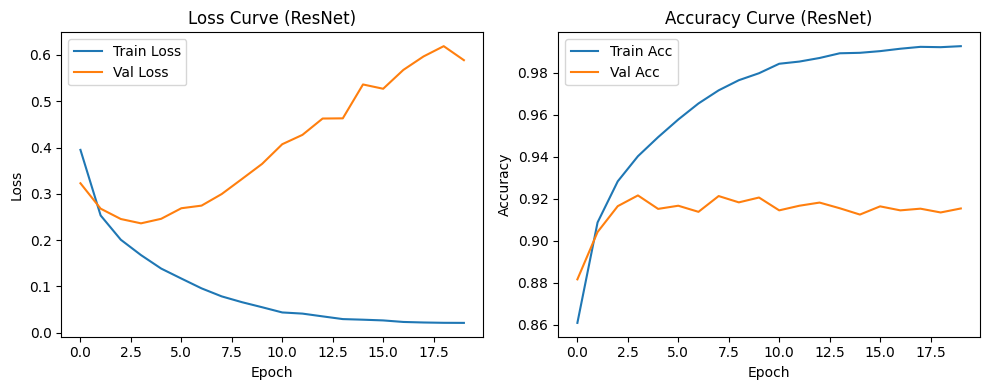

In [ ]:
# Neural Network 4 with skip-connection

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])
transform_plain = transforms.ToTensor()

train_dataset_full = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform_aug)
test_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform_plain)

train_size = 50000
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])
val_dataset.dataset.transform = transform_plain

batch_size = 64
train_loader_aug = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_aug = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class FashionResNet(nn.Module):
    def __init__(self):
        super(FashionResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 14 * 14, 10)

    def forward(self, x):
        out1 = F.relu(self.conv1(x))
        out2 = self.conv2(out1)
        out2 = F.relu(out1 + out2)
        out3 = F.relu(self.conv3(out2))
        out3 = self.pool(out3)
        out3 = out3.view(out3.size(0), -1)
        out = self.fc(out3)
        return out

model_resnet = FashionResNet().to(device)
print(model_resnet)
print("Total parameters:", sum(p.numel() for p in model_resnet.parameters()))
summary(model_resnet, input_size=(1, 28, 28))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

epochs = 20
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

for epoch in range(1, epochs + 1):
    model_resnet.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader_aug:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_resnet(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
    avg_train_loss = total_loss / total
    train_accuracy = correct / total

    model_resnet.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in val_loader_aug:
            data, target = data.to(device), target.to(device)
            output = model_resnet(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            val_correct += (predicted == target).sum().item()
            val_total += target.size(0)
    avg_val_loss = val_loss / val_total
    val_accuracy = val_correct / val_total

    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs} - "
              f"Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f} - "
              f"Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (ResNet)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve (ResNet)")
plt.legend()

plt.tight_layout()
plt.show()


Добавление skip-соединения дало хороший результат — модель обучается быстрее и эффективнее. Точность на обучении выросла до 97.9%, на валидации — стабильно держится около 92%. Однако, как и в прошлой задаче, видно лёгкое переобучение: train loss сильно падает, а val loss — начинает расти после середины. Тем не менее, ResNet-архитектура показывает себя лучше базовой CNN, особенно по скорости сходимости и стабильности обучения. Хороший вариант для дальнейшего усложнения модели.